In [1]:
import pandas as pd
import numpy as np
import os
sep=os.sep
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import json
from core.models import MSANNet
from core.measurements import Prf1a
import random
from torch.utils.data import Dataset
from core.torchutils import NNDataLoader
import core.data_parser as data_parser
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import copy
from core.utils import create_k_fold_splits
from sklearn import svm
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [3]:
df = [l.strip() for l in open('pooled/labels/pooled_labels.csv').readlines()]
header, df = df[0], df[1:]
create_k_fold_splits(df, k=10, save_to_dir='pooled/splits/', shuffle_files=True)

Valid: True
Valid: True
Valid: True
Valid: True
Valid: True
Valid: True
Valid: True
Valid: True
Valid: True
Valid: True


In [4]:
class FreeSurferDataset(Dataset):
    def __init__(self):
        self.indices = []

    def load_indices(self, split_list):
        for line in split_list:
            site, file, label, _, _ = line.split(',')
            label = int(label)
            dir = f'test/input/{site}/simulatorRun/subject_stats_S0{site[-1]}'
            data, errors = data_parser.parse_subj_volume_files(dir, [file])
            x = data.iloc[0].values
            self.indices.append([x, label])

    def __getitem__(self, ix):
        x, y = self.indices[ix]
        return {'inputs': torch.tensor(x), 'labels': torch.tensor(y)}

    def __len__(self):
        return len(self.indices)

    def get_loader(self, shuffle=False, batch_size=None, num_workers=0, pin_memory=True, **kw):
        return NNDataLoader.get_loader(dataset=self, shuffle=shuffle, batch_size=batch_size,
                                       num_workers=num_workers, pin_memory=pin_memory, **kw)

In [5]:
DATASETS = []
splits_dir = 'pooled/splits/'
for k, split_file in enumerate(os.listdir(splits_dir)):
    split = json.loads(open('pooled/splits/' + os.sep + split_file).read())
    train_dset = FreeSurferDataset()
    train_dset.load_indices(split['train'])
    
    val_dset = FreeSurferDataset()
    val_dset.load_indices(split['validation'])
    
    test_dset = FreeSurferDataset()
    test_dset.load_indices(split['test'])
    DATASETS.append([k, train_dset, val_dset, test_dset])
    print(k, len(train_dset), len(val_dset), len(test_dset))

0 202 26 26
1 204 25 25
2 204 25 25
3 204 25 25
4 202 26 26
5 204 25 25
6 202 26 26
7 204 25 25
8 203 26 25
9 203 25 26


In [6]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

In [7]:
def evaluation(model, eval_dataset):
    model.eval()
    
    """
    Validation
    """
    eval_loader = eval_dataset.get_loader( batch_size=8,num_workers=2, pin_memory=True)
    vloss = 0
    score = Prf1a()
    with torch.no_grad():
        for i, batch in enumerate(eval_loader):
                inputs = batch['inputs'].to(device).float()
                labels = batch['labels'].to(device).long()
                
                out = F.log_softmax(model(inputs), 1)
                _, predicted = torch.max(out, 1)
                vloss += F.nll_loss(out, labels).item() * inputs.shape[0]

                score.add_tensor(predicted, labels)
                
    return vloss/len(eval_dataset), score

In [8]:
EPOCHS = 11
BATCH_SZ = 32
LR = 0.001
IN_SIZE = 66
NUM_CLASSES = 2
HIDDEN = [16, 8, 4, 2]
LOGS= []
seed = 244627#np.random.randint(1e3, 1e10)
print('SEED: ', seed)
final_score_nn = Prf1a()
for k, train_dataset, val_dataset, test_dataset in DATASETS:
    
    train_loader = train_dataset.get_loader(shuffle=True, batch_size=BATCH_SZ,
                                    num_workers=2, pin_memory=True, drop_last=True)
    
    test_loader = test_dataset.get_loader(shuffle=True, batch_size=BATCH_SZ,
                                    num_workers=2, pin_memory=True)
    
    device = torch.device('cpu')
    model = MSANNet(in_size=IN_SIZE, 
                    hidden_sizes=HIDDEN, 
                    out_size=NUM_CLASSES, dropout_in=[])
    torch.manual_seed(seed)
    initialize_weights(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
      
    best_score = 0
    best_ep = 0
    best_model = None
    TRAIN_LOGS, VAL_LOGS = [], []
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        score = Prf1a()
        for i, batch in enumerate(train_loader):
            inputs = batch['inputs'].to(device).float()
            labels = batch['labels'].to(device).long()

            optimizer.zero_grad()
            out = F.log_softmax(model(inputs), 1)
            _, predicted = torch.max(out, 1)


            score.add_tensor(predicted, labels)
            
            wt = torch.randint(1, 11, (2, 1)).float()
            loss = F.nll_loss(out, labels, weight=None)
            loss.backward()
            running_loss += loss.item()*inputs.shape[0]

            optimizer.step()

        TRAIN_LOGS.append([running_loss/len(train_dataset), *score.prfa()])  
        
        vloss, vscore = evaluation(model, val_dataset)
        VAL_LOGS.append([vloss, *vscore.prfa()])
        
        if vscore.f1 > best_score:
            best_score = vscore.f1
            best_model = copy.deepcopy(model)
            best_ep = epoch
            
    test_loss, test_score = evaluation(best_model, test_dataset)
    final_score_nn.accumulate(test_score)
    LOGS.append([k, test_score, TRAIN_LOGS, VAL_LOGS])
    print(k, test_score.prfa())
'Global', final_score_nn.prfa()

SEED:  244627
0 [0.501, 1.001, 0.66878, 0.501]
1 [0.521, 1.001, 0.68631, 0.521]
2 [0.641, 1.001, 0.78254, 0.641]
3 [0.361, 1.001, 0.53163, 0.361]
4 [0.36942, 1.001, 0.54067, 0.53946]
5 [0.481, 1.001, 0.65077, 0.481]
6 [0.27023, 1.001, 0.42657, 0.27023]
7 [0.521, 1.001, 0.68631, 0.521]
8 [0.69665, 0.88989, 0.7825, 0.641]
9 [0.42408, 1.001, 0.59676, 0.42408]


('Global', [0.47855, 0.98419, 0.64498, 0.48919])

### SVM

In [9]:
svm_scores = []
for k, train_dat, val_dat, test_dat in DATASETS:
    X, Y = [], []
    X+=[x for x, _ in train_dat.indices]
    Y+=[y for _, y in train_dat.indices]
    X+=[x for x, _ in val_dat.indices]
    Y+=[y for _, y in val_dat.indices]
    
    test_X = [x for x, _ in test_dat.indices]
    test_Y = [y for _, y in test_dat.indices]
    
    clf = svm.NuSVC(kernel='rbf')
    clf.fit(np.array(X), np.array(Y))
    predictions = clf.predict(np.array(test_X))
    score = Prf1a()
    score.add_array(np.array(predictions), np.array(test_Y))
    svm_scores.append(score)
    print(f'fold {k}: train {len(X)}, test {len(test_Y)}', score.prfa())

fold 0: train 228, test 26 [0.501, 0.69331, 0.58267, 0.501]
fold 1: train 229, test 25 [0.451, 0.69331, 0.5475, 0.401]
fold 2: train 229, test 25 [0.701, 0.4385, 0.54051, 0.521]
fold 3: train 229, test 25 [0.201, 0.11211, 0.14494, 0.521]
fold 4: train 228, test 26 [0.30869, 0.57243, 0.40209, 0.53946]
fold 5: train 229, test 25 [0.501, 0.58433, 0.54047, 0.521]
fold 6: train 228, test 26 [0.38562, 0.71529, 0.50209, 0.61638]
fold 7: train 229, test 25 [0.42957, 0.23177, 0.30209, 0.441]
fold 8: train 229, test 25 [0.626, 0.27878000000000003, 0.38677, 0.361]
fold 9: train 228, test 26 [0.42205, 0.72827, 0.5354, 0.46254]


In [70]:
# pth = 'test/input/'
# sites = json.loads(open('test/inputspec_multi.json').read())
# for site, spec in enumerate(inspec):
#     base_dir = pth+os.sep+f'local{site}' + os.sep + 'simulatorRun'
#     files = os.listdir(base_dir + os.sep + f'subject_stats_S0{site}')
#     create_k_fold_splits(files, k=10, save_to_dir=base_dir+os.sep+f'split_S0{site}')
# #     break

In [11]:
import glob

In [315]:
site_scores = []
site_ = []
pth = 'test/output/remote/simulatorRun/'
for file in glob.glob(pth+'*/*_scores.txt'):
    line = open(file).readline().split(':')[1].strip()[1:-1]
    tp, tn, fp, fn = [int(l) for l in line.split(',')]
    score = Prf1a()
    score.add(tp=tp, tn=tn, fp=fp, fn=fn)
    site_scores.append(score)
    site_.append((tp, tn, fp, fn))

In [252]:
SCORE = [['Experiment','Score','Value']]
final_dist, final_pooled, final_svm = Prf1a(), Prf1a(), Prf1a()
for a, b, c in zip(site_scores, LOGS, svm_scores):
    b = b[1]
    final_dist.accumulate(a)
    final_pooled.accumulate(b)
    final_svm.accumulate(c)
    
    SCORE.append(['Distributed NN', 'Precision', a.precision])
    SCORE.append(['Distributed NN', 'Recall', a.recall])
    SCORE.append(['Distributed NN', 'F1', a.f1])
    
    SCORE.append(['Pooled NN', 'Precision', b.precision])
    SCORE.append(['Pooled NN', 'Recall', b.recall])
    SCORE.append(['Pooled NN', 'F1', b.f1])
    
    SCORE.append(['Pooled SVM', 'Precision', c.precision])
    SCORE.append(['Pooled SVM', 'Recall', c.recall])
    SCORE.append(['Pooled SVM', 'F1', c.f1])

In [253]:
df = pd.DataFrame(SCORE[1:], columns=SCORE[0])

In [254]:
df.head(3)

,Experiment,Score,Value
0,Distributed NN,Precision,0.39230
1,Distributed NN,Recall,0.90100
2,Distributed NN,F1,0.54761


In [309]:
plt.rcParams['figure.figsize'] = 16, 10
sns.set_context("talk")

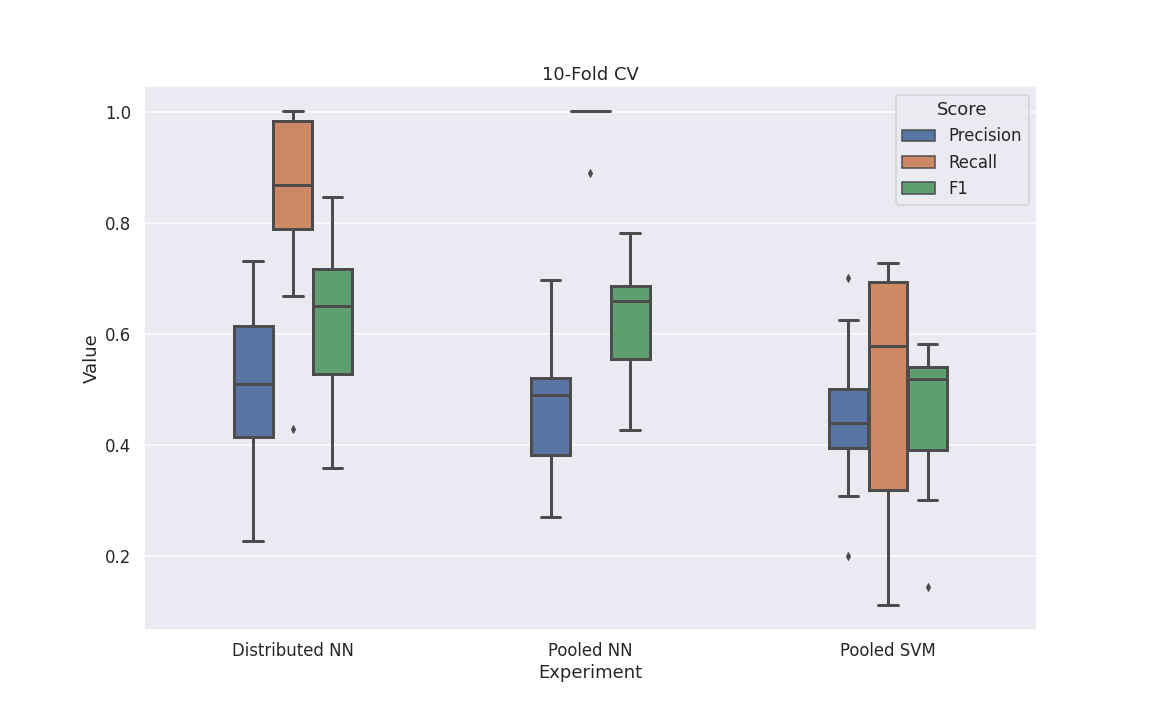

In [313]:
plt.title('10-Fold CV')
ax = sns.boxplot(x='Experiment', y='Value', hue='Score', data=df, linewidth=3, dodge=True, width=0.4)
# sns.swarmplot(x='Experiment', y='Value', hue='Score', data=df, dodge=True);
plt.savefig('box.png')
plt.close('all')
Image.open('box.png')

In [167]:
print('Distributed Global PRF1A: ', final_dist.prfa())
print('     Pooled Global PRF1A: ', final_pooled.prfa())
print('        SVM Global PRF1A: ', final_svm.prfa())

Distributed Global PRF1A:  [0.5109, 0.86655, 0.64381, 0.54824]
     Pooled Global PRF1A:  [0.47855, 0.98419, 0.64498, 0.48919]
        SVM Global PRF1A:  [0.45769, 0.48839, 0.47354, 0.48919]


In [317]:
pd.DataFrame(site_, columns=['TP','TN', 'FP', 'FN'])

,TP,TN,FP,FN
0,9,1,14,1
1,7,5,11,2
2,5,0,17,1
3,13,0,14,0
4,15,0,11,0
5,3,15,3,4
6,19,0,7,0
7,13,1,12,1
8,9,10,4,2
9,10,4,6,5
